In [2]:
import numpy as np
import scipy as sci
import visualizations as vis
from DelayEmbedding import optimizedDErefactor as DE
from simulator import networks
from simulator import helpers as sim_helpers
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import os
import scipy.interpolate as interpolate
from matplotlib import colormaps

#### CCM on the Baby Chaos System

In this demo we will look at the implementation of Convergent Cross Mapping on the "Baby Chaos Network". We will first compute the time series, the Cross-Correlation matrix, eCCM matrices, and finally the Interventional Connectivity matrix to check our predictions.

### RNN Simulation Helpers

In [3]:
def CrossCorrs(X,t=None,n_bins=100,n_perms=20):
    T_bin = X.shape[1]//n_bins
    N = X.shape[0]
    X_bin = np.zeros((N,n_bins,T_bin))
    curr_t = 0
    for i in range(n_bins):
        curr_X = X[:,curr_t:curr_t+T_bin]
        curr_X = curr_X-np.nanmean(curr_X,axis=1)[:,np.newaxis]
        X_bin[:,i,:] = curr_X/np.sqrt(np.sum(np.square(curr_X),axis=1))[:,np.newaxis] #np.pad(curr_X,((0,0),(T_bin//2,T_bin//2 + (T_bin%2))),mode='constant',constant_values=(0,0))/np.sqrt(np.sum(np.square(curr_X),axis=1))[:,np.newaxis]
        curr_t += T_bin
    Crosses = np.zeros((N,N,2*T_bin-1))
    for i in range(N):
        for j in range(N):
            Crosses[i,j,:] = np.nanmean(np.array([sci.signal.correlate(X_bin[i,k,:],X_bin[j,k,:],mode='full') for k in range(n_bins)]),axis=0)
    Perm_Crosses = np.zeros((n_perms,n_bins,N,N,2*T_bin-1))
    for p in range(n_perms):
        bin_perms = [[np.random.permutation(np.arange(n_bins)) for n in range(N)] for m in range(N)]
        bin_perms2 = [[np.random.permutation(np.arange(n_bins)) for n in range(N)] for m in range(N)]
        for i in range(N):
            for j in range(N):
                Perm_Crosses[p,:,i,j,:] = np.array([sci.signal.correlate(X_bin[i,bin_perms[i][j][k],:],X_bin[j,bin_perms2[i][j][k],:],mode='full') for k in range(n_bins)])
    return Crosses, np.arange(-T_bin,T_bin-1), Perm_Crosses

def plotxcorr(XCorr,tshift,i,j):
    plt.plot(tshift,XCorr[i,j,:].T)
    plt.axhline(XCorr[i,j,np.argmax(np.abs(XCorr[i,j,:]))],linestyle='--')
    plt.axvline(tshift[np.argmax(np.abs(XCorr[i,j,:]))])
    plt.show()

def ShiftCorrSign(XCorrs,tshift,eval_at = None, plot_vals = None,c_name='plasma',figsize=(14,14)):
    N,M = XCorrs.shape[:2]
    vals = np.zeros(XCorrs.shape[:2])
    vals_at = np.zeros(XCorrs.shape[:2])
    peaks = np.zeros(XCorrs.shape[:2],dtype=int)
    zero_shift = np.argmin(np.abs(tshift))
    for i in range(N):
        for j in range(M):
            # TODO: This actually picks a maximum, not a peak (so if the peak on one side is still large near 0 then it might filter out the real one)
            forward = np.array(XCorrs[i,j,zero_shift:])
            peaks[i,j] = np.argmax(np.abs(forward))
            vals[i,j] = forward[np.argmax(np.abs(forward))]
            if eval_at is not None:
                vals_at = forward[eval_at[i,j]]
    if plot_vals is not None:
        c = colormaps[c_name](np.linspace(0,1,len(plot_vals)))
        fig = plt.figure(figsize=figsize)
        ax = plt.axes()
        n = 0
        for i,j in plot_vals:
            if i != j:
                ax.plot(tshift,XCorrs[i,j,:],color=c[n])
                ax.axvline(tshift[peaks[i,j]+zero_shift],color=c[n],label=f'Corr({i},{j}) lag t={round(tshift[peaks[i,j]+zero_shift])}')
                ax.axvline(tshift[-(peaks[j,i])+zero_shift],color=c[n],label=f'Corr({j},{i}) lag t={round(tshift[peaks[j,i]+zero_shift])}')
            else:
                ax.plot(tshift,XCorrs[i,j,:],color=c[n],label=f'Autocorr({i})')

            n+=1

        ax.set_xlabel('t')
        ax.set_ylabel('Corr($X_i(\\tau)$,$X_j(\\tau-t)$)')
        plt.legend()
        plt.ylim(-1,1)
        plt.show()
    return peaks, vals, vals_at

def ShiftSigns(X,bins=100):
    Xcorrs,tshift = CrossCorrs(X,n_bins=bins)
    return ShiftCorrSign(Xcorrs,tshift)

In [4]:
def PlotCCM(CCM,lags,surrs,dims,i,j,lag_range = None,figsize = (26,12)):
    """
    PlotCCM:
    Plots eCCM with surrogate bounds for significance
    CCM: number of tested dims x N x N x lag nums matrix of ccm values
    lags: numbers corresonding to tested lags for eCCM
    dims: the dimension of each tested embedding
    i: efferent index
    j: afferent index
    lag_range: the indices lags you actually want to plot
    figsize: size of figure
    
    outputs nothing it just plots
    """
    l_range = None
    if lag_range is None:
        l_range = np.arange(lags.shape[0])
    else:
        l_range = np.array(lag_range)
    fig,axs = plt.subplots(nrows=1,ncols=2,figsize=figsize)
    for d in range(CCM.shape[0]):
        axs[0].plot(lags,CCM[d,i,j,:],label=f'dim = {dims[d]}')
    axs[0].axhspan(np.min(surrs[:,i,j]),np.max(surrs[:,i,j]),label='p>0.01',alpha=0.2,color=[1,0,1])
    axs[0].legend(loc=1)
    for l in range(l_range.shape[0]):
        axs[1].plot(dims[:CCM.shape[0]],CCM[:,i,j,l_range[l]],label=f'lag = {lags[l_range[l]]}')
    axs[1].axhspan(np.min(surrs[:,i,j]),np.max(surrs[:,i,j]),label='p>0.01',alpha=0.2,color=[1,0,1])
    axs[1].legend(loc=4)

    plt.show()

def PlotSingleDimCCM(CCM,lags,surrs,pairs=[[0,1],[0,2]],figsize=(14,16),colormap = 'plasma',titlestr = 'CCM'):
    """
    PLotSingleDimCCM:
    args:
    CCM: N x N x lag_num matrix of CCM values
    lags: the array corresponding to actual lag values
    surrs: surr_num x N x N matrix of surrogate distribution CCMs
    pairs: the efferent, afferent pairs you want to plot
    figsize: tuple of size_x , size_y for the image
    colormap: the cmap (see matplotlib) you want the colors of the plots to be
    titlestr: The title of the plot
    """
    
    pair_num = len(pairs)
    fig,axs = plt.subplots(nrows=pair_num,ncols=1,figsize=figsize)
    axs[0].set_title(titlestr)
    for k in range(pair_num):
        i,j = pairs[k]
        axs[k].plot(lags,CCM[i,j,:],label=f'p(X{j}|X{i})')
        axs[k].axhspan(np.min(surrs[:,i,j]),np.max(surrs[:,i,j]),label='Surrogate Bounds',alpha=0.3,color=[1,0,0])
        axs[k].legend()
    plt.legend()
    plt.show()


## Baby Chaos System

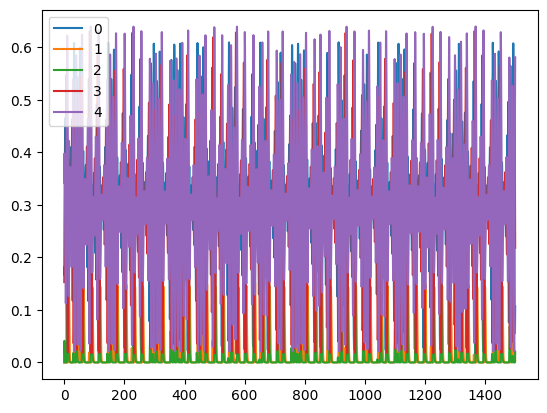

In [43]:
#directed graph on which a CTLN defined in the Curto paper produces chaos
#for each node in the dictionary the values are the nodes to which node i has 
#a directed edge
baby_chaos_graph={1:[2,4], 2:[5], 3:[2,4],4:[5],5:[1,3]}

#number of vertices in the graph
def CTLN(G,epsilon,delta):
    ''' Creates the W_ij of a CTLN according to Carina Curto's paper for the underlying graph which
    is given as a dictionary
    '''
    n=len(G)
    x=np.arange(n)
    W=np.zeros((n,n))
    for j in G.keys():
        W[np.array(G[j])-1,j-1]=-1+epsilon
        y=np.setdiff1d(x,np.concatenate((np.array(G[j])-1,np.array([j-1]))))
        W[y,j-1]=-1-delta
    return W
        
        
epsilon=0.25
delta=0.5

W=CTLN(baby_chaos_graph,epsilon,delta)  

def relu(x):
    return np.multiply(x, (x>0).astype(int))
    

def BabyChaosDynamics(x0,W,b,phi,T,dt):
    time_array=np.arange(0,T,dt)
    x_t=np.zeros((len(x0),len(time_array)))
    x_t[:,0]=x0
    for i in range(1,len(time_array)):
        x_t[:,i]=(1-dt)*x_t[:,i-1]+dt*phi(np.matmul(W,x_t[:,i-1])+b)
    
    return x_t

x0=np.zeros(5)
#change initial conditions here for the different attractors, the different cycles for the chaotic 
#attractors are [0,1,4], [1,2,4],[2,3,4],[0,3,4]. Just set the initial conditions corresponding to these
#neurons to nonzero
x0[[0,3,4]]=np.random.uniform(0,0.5,size=3)

b=np.ones(5)

dt=0.01
T=1500


x=BabyChaosDynamics(x0, W, b, relu, T, dt)

time_array=np.arange(0,T,dt)

plt.figure()
for i in range(5):
    plt.plot(time_array,x[i],label=i)

plt.legend()
plt.show()
plt.close()

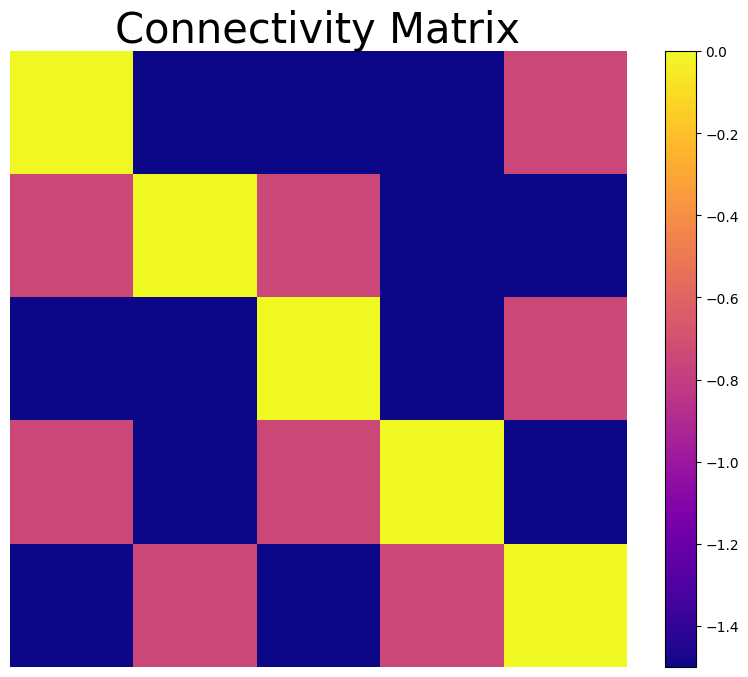

In [44]:
vis.visualize_matrix(W,titlestr='Connectivity Matrix',cmap='plasma')


### Cross correlagram

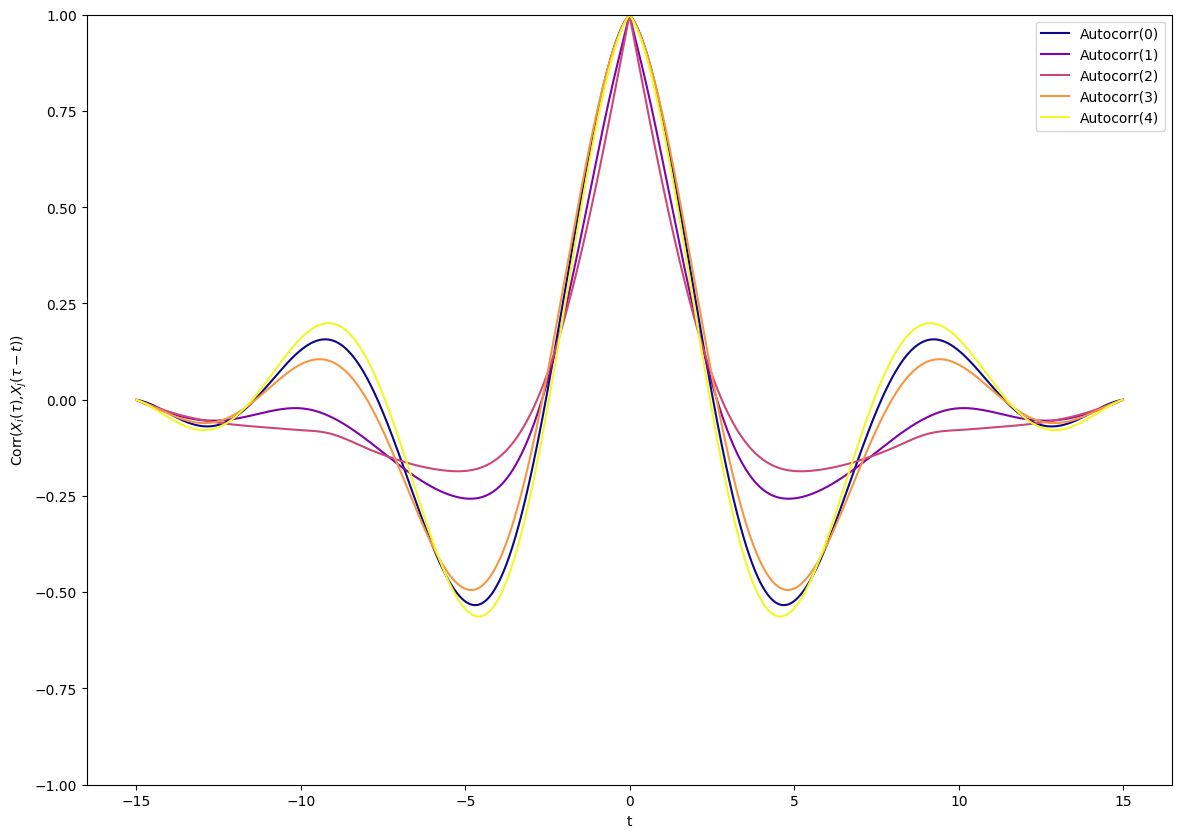

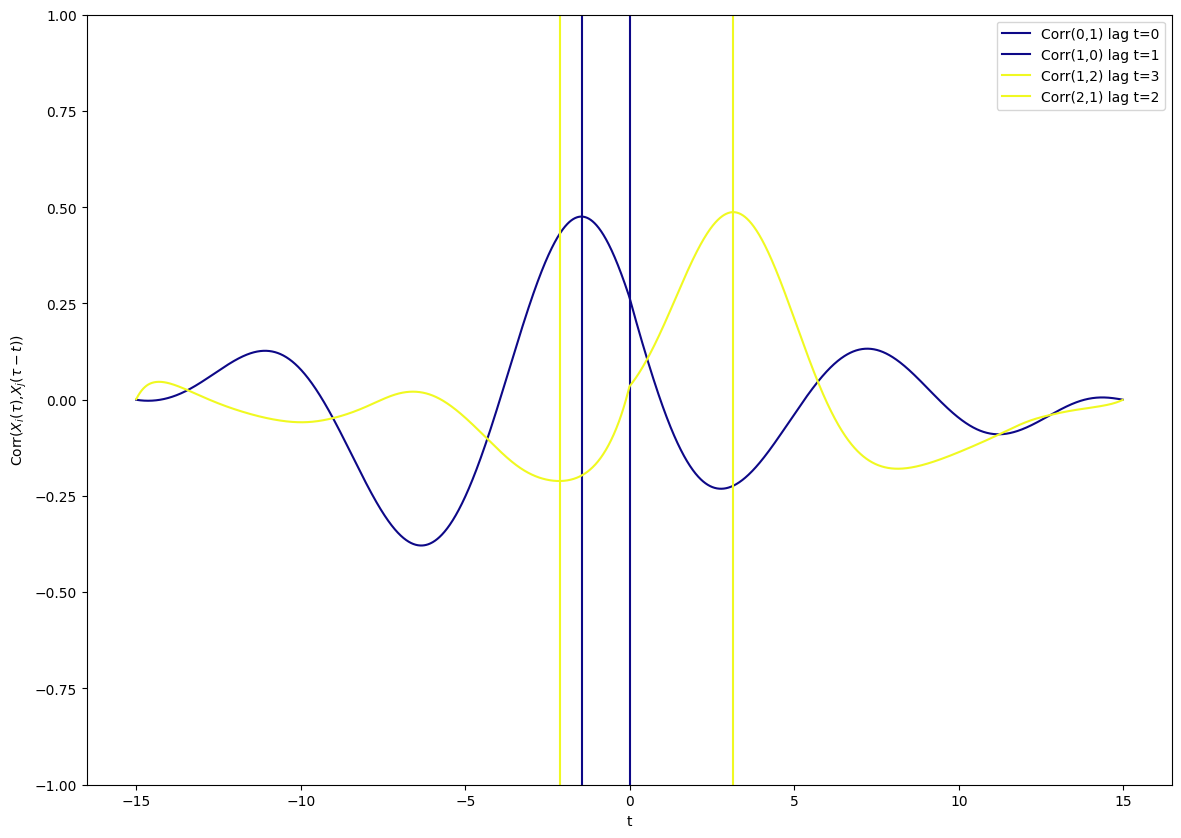

In [47]:
xcorrs,tshift,pbins = CrossCorrs(x,n_bins=100)
zero_time = np.argmin(np.abs(tshift))
peaks, vals, vals_at  = ShiftCorrSign(xcorrs,tshift*dt,plot_vals=[[0,0],[1,1],[2,2],[3,3],[4,4]],figsize=(14,10))
peaks, vals, vals_at  = ShiftCorrSign(xcorrs,tshift*dt,plot_vals=[[0,1],[1,2]],figsize=(14,10))



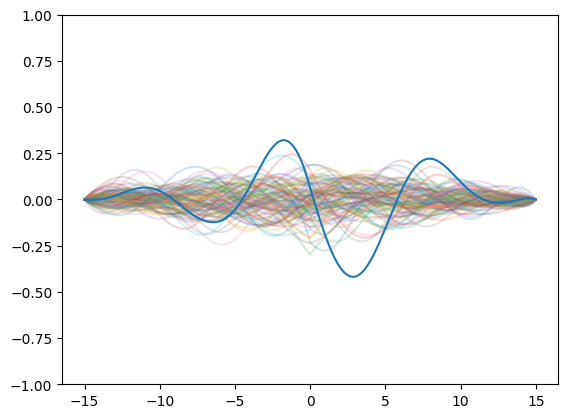

In [51]:
#for j in range(20):
plt.plot(tshift*dt,np.nanmean(pbins[:,:,2,0,:],axis=0).T,alpha=0.2)
plt.plot(tshift*dt,xcorrs[2,0,:])
plt.ylim(-1,1)
plt.show()

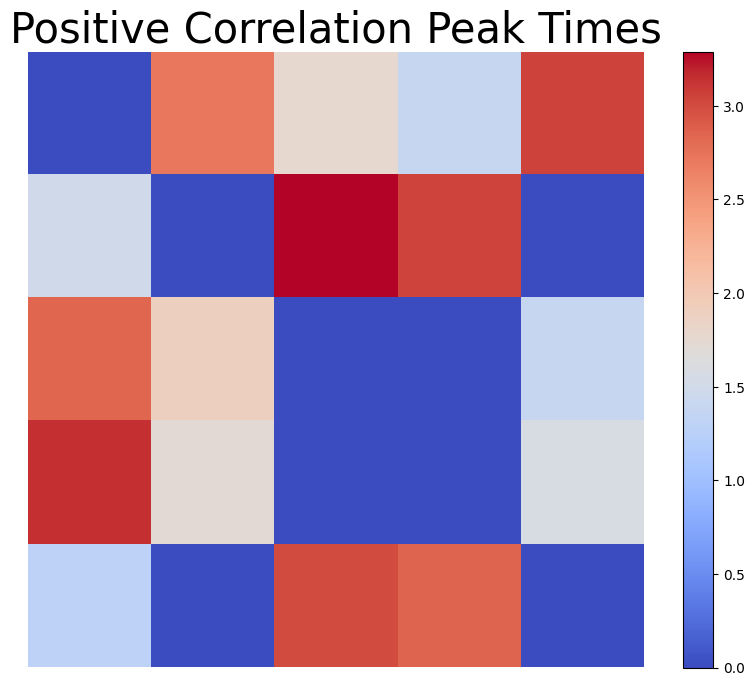

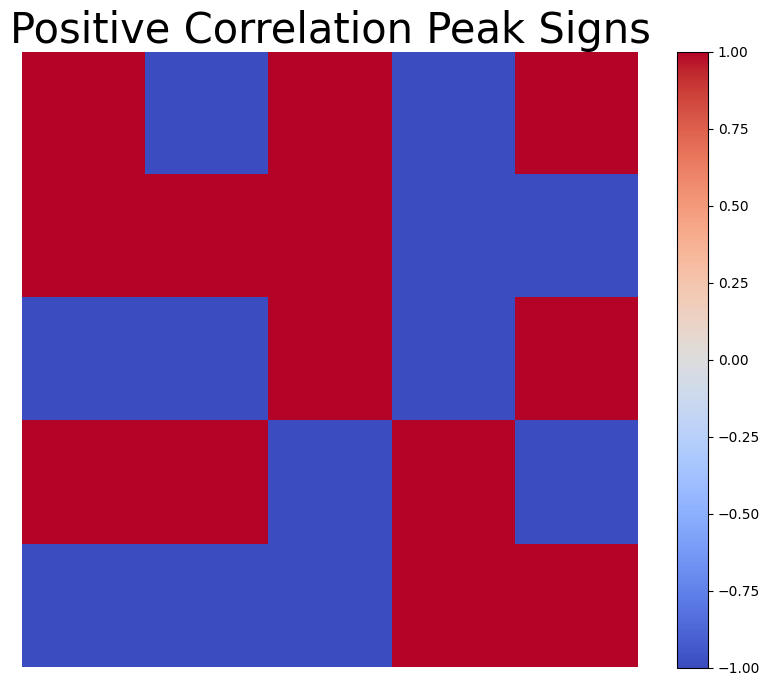

In [56]:
peak_times = tshift[peaks.flatten()+zero_time].reshape(peaks.shape)*dt
vis.visualize_matrix(peaks*dt,titlestr='Positive Correlation Peak Times')
vis.visualize_matrix(np.sign(vals),titlestr='Positive Correlation Peak Signs')

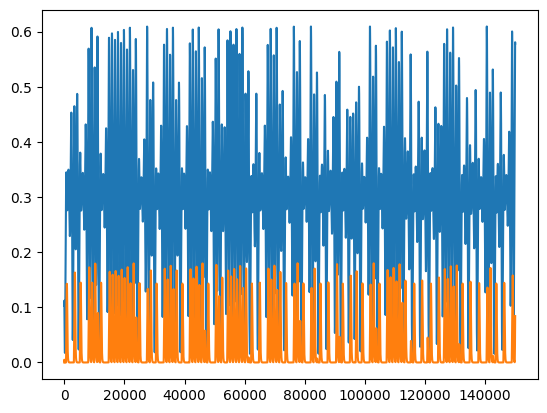

In [58]:
plt.plot(x[0,:])
plt.plot(x[1,:])


Delay SPace Projection of Different Neurons

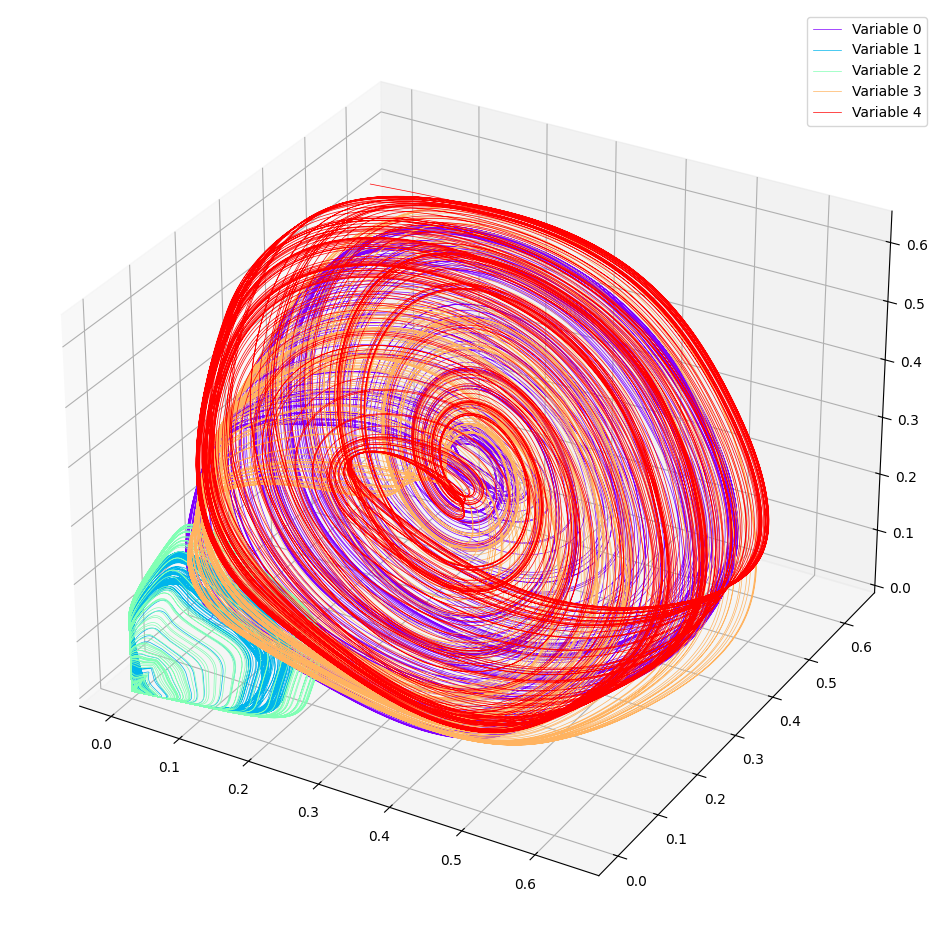

In [61]:
vis.MultiDelayPlot3D(x.T[:,:],200,cmap='rainbow')


### Baby Chaos CCM

Saving Data

In [64]:
out_path= './outputs/BabyChaosDemo1/'
if not os.path.exists(out_path):
    os.mkdir(out_path)


In [65]:
np.save(out_path+'TS.npy',x)
np.save(out_path+'W.npy',W)

### Parameters for CCM

Your performance may vary based on the size of the system and your computing power

In [66]:
x = np.load(out_path+'TS.npy').T

##### Choosing the Optimum Delay

To pick the optimum delay for the embedding, we find the first minima of the Mutual Information between each Time series and the delayed version of itself

However this is actually difficult to account for depending on the resolution of the data so its good to just arbitrarily choose in practice since CCM will work regardless, since changing the delay length is still a diffeomorphism of the attractor.

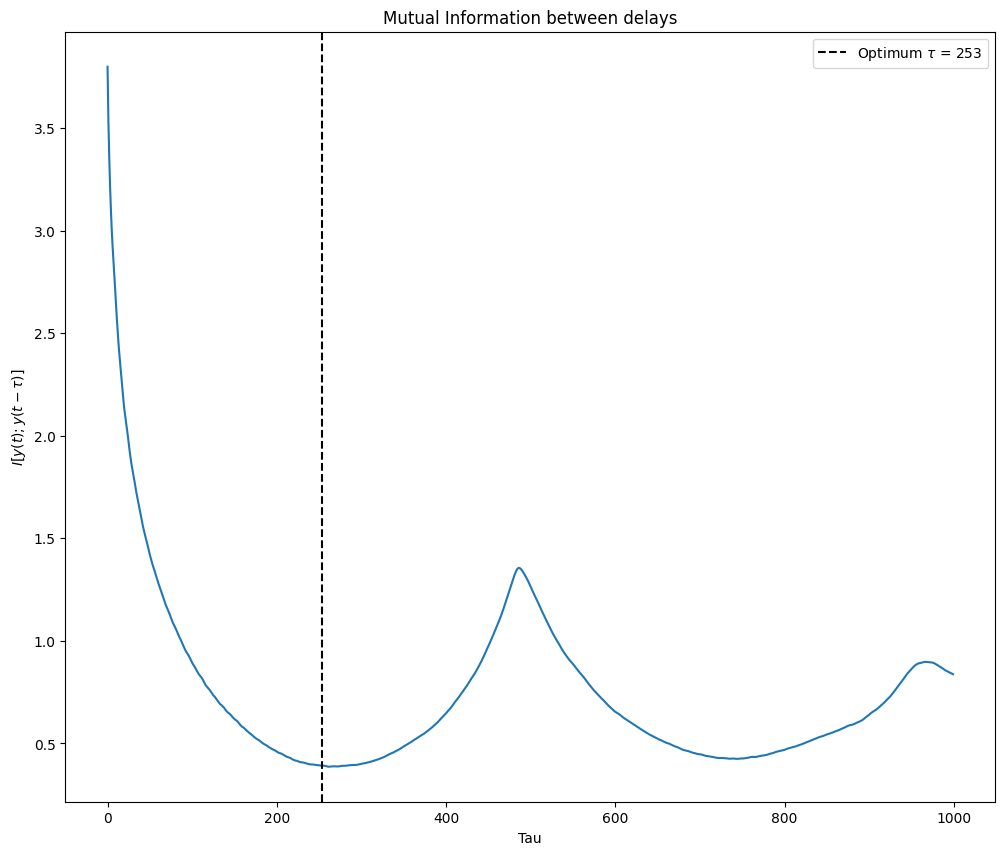

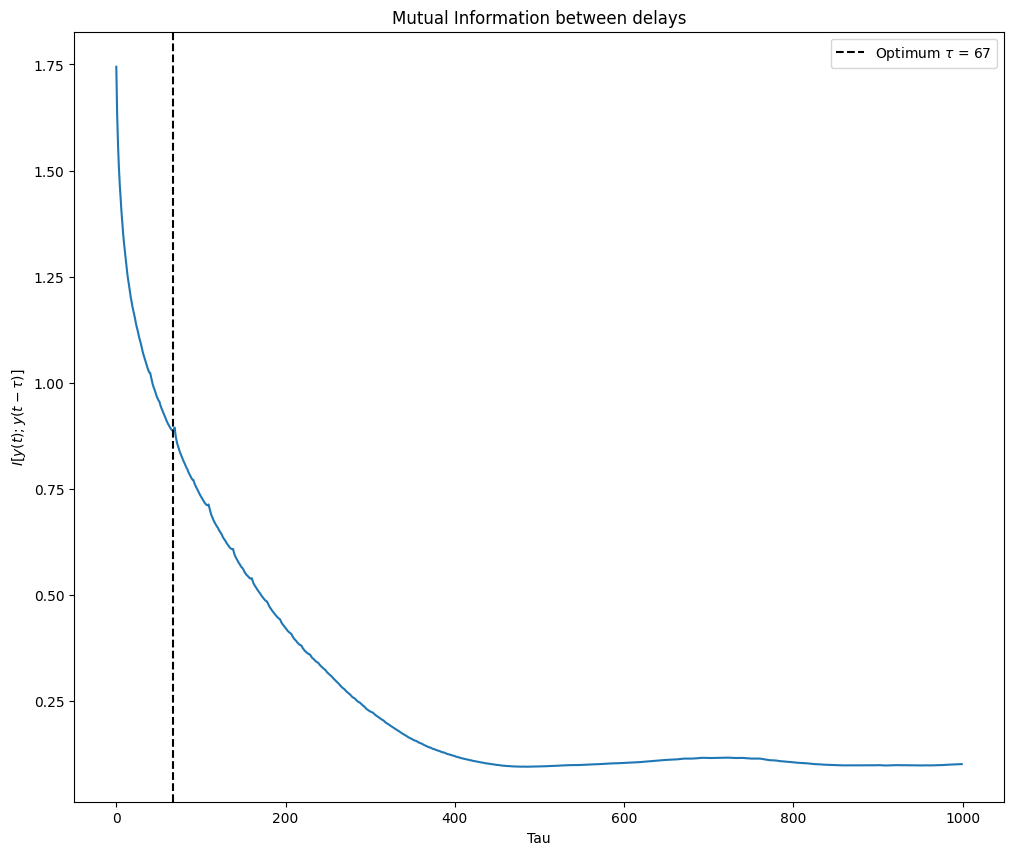

(67,
 array([1.74458524, 1.63313784, 1.5628057 , 1.51047416, 1.47050517,
        1.43811484, 1.40670939, 1.37873507, 1.35330483, 1.33128121,
        1.31267864, 1.29444803, 1.27437482, 1.25727976, 1.2427324 ,
        1.2301462 , 1.21540799, 1.20233282, 1.19207842, 1.18004453,
        1.17103278, 1.1610207 , 1.15292796, 1.14173738, 1.13256259,
        1.12524691, 1.11575749, 1.10698908, 1.10015664, 1.09252071,
        1.08329008, 1.07499095, 1.06723185, 1.06058587, 1.05326138,
        1.04690524, 1.04081811, 1.03453494, 1.02874872, 1.02437478,
        1.02354006, 1.01445995, 1.00458968, 0.99652003, 0.99017912,
        0.98514341, 0.97901765, 0.97311885, 0.96672555, 0.96226363,
        0.95819504, 0.95550141, 0.94786747, 0.94221822, 0.93695271,
        0.9322328 , 0.92713267, 0.9223342 , 0.91791523, 0.91264774,
        0.90834604, 0.90368694, 0.90043176, 0.8964291 , 0.89308784,
        0.89019769, 0.88822196, 0.88786354, 0.89028267, 0.89466297,
        0.8770489 , 0.86558624, 0.85688337,

In [69]:
DE.ApproximatebestTau(x[:,0],taumax=1000,plot=True)
DE.ApproximatebestTau(x[:,2],taumax=1000,plot=True)


Testing for Connections at small dimension, since we already know for this system the configuration space is d $\leq$ 5

In [70]:
recorded_neurons = x.shape[1]
embedding_max_dim = x.shape[1]
connection_dim=3
delay = 200
kfolds = 5
surr_num = 20
lag_arr = np.arange(-20,21)

PLEASE PUT IN THE MAX CORES YOU WANT TO USE IN THE NEXT CELL

In [71]:
MAX_PROCESSES = 64

In [72]:
fcf_vals,ccm_vals = DE.DirectConnectionCCM(x,delay=delay,connection_dim=connection_dim,surrogate_dim=embedding_max_dim,n_surrogates=surr_num
                                           ,lags=lag_arr,retain_test_set=True,normal_pval=True,save=True,save_path=out_path,max_processes=MAX_PROCESSES
                                           ,kfolds=kfolds)

Using Delay: 200


Computing Directionality: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]

Creating twin surrogates
Surrogates for fold 0



Surrogate NNS: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Surrogate Map generation time: 8.727844518000001 s


100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


Surrogates for fold 1


Surrogate NNS: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Surrogate Map generation time: 8.423938079000001 s


100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Surrogates for fold 2


Surrogate NNS: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Surrogate Map generation time: 8.373624814000001 s


100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


Surrogates for fold 3


Surrogate NNS: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Surrogate Map generation time: 9.233662258 s


100%|██████████| 5/5 [00:22<00:00,  4.41s/it]


Surrogates for fold 4


Surrogate NNS: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Surrogate Map generation time: 8.205123239 s


100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


Finished Surrogate Generation in: 141.535182138 s


100%|██████████| 25/25 [00:02<00:00, 11.88it/s]


Finished Surrogate evaluation in: 2.377430033 s


100%|██████████| 25/25 [00:02<00:00, 12.48it/s]


Finished Surrogate evaluation in: 4.626981224000001 s


100%|██████████| 25/25 [00:02<00:00, 12.23it/s]


Finished Surrogate evaluation in: 6.915902163 s


100%|██████████| 25/25 [00:01<00:00, 13.21it/s]


Finished Surrogate evaluation in: 9.061119396 s


100%|██████████| 25/25 [00:01<00:00, 12.91it/s]


Finished Surrogate evaluation in: 11.243723476000001 s


100%|██████████| 25/25 [00:01<00:00, 13.46it/s]


Finished Surrogate evaluation in: 13.337777338 s


100%|██████████| 25/25 [00:02<00:00, 12.15it/s]


Finished Surrogate evaluation in: 15.628896049000002 s


100%|██████████| 25/25 [00:01<00:00, 14.25it/s]


Finished Surrogate evaluation in: 17.613305414000003 s


100%|██████████| 25/25 [00:01<00:00, 14.03it/s]


Finished Surrogate evaluation in: 19.665232192 s


100%|██████████| 25/25 [00:01<00:00, 13.23it/s]


Finished Surrogate evaluation in: 21.789643378 s


100%|██████████| 25/25 [00:01<00:00, 13.24it/s]


Finished Surrogate evaluation in: 23.909953917000003 s


100%|██████████| 25/25 [00:01<00:00, 13.21it/s]


Finished Surrogate evaluation in: 26.037797857 s


100%|██████████| 25/25 [00:01<00:00, 13.93it/s]


Finished Surrogate evaluation in: 28.090721106 s


100%|██████████| 25/25 [00:01<00:00, 13.33it/s]


Finished Surrogate evaluation in: 30.210961128 s


100%|██████████| 25/25 [00:01<00:00, 12.83it/s]


Finished Surrogate evaluation in: 32.391991557000004 s


100%|██████████| 25/25 [00:01<00:00, 13.88it/s]


Finished Surrogate evaluation in: 34.441622907 s


100%|██████████| 25/25 [00:01<00:00, 13.80it/s]


Finished Surrogate evaluation in: 36.483753343000004 s


100%|██████████| 25/25 [00:01<00:00, 13.26it/s]


Finished Surrogate evaluation in: 38.606231702 s


100%|██████████| 25/25 [00:01<00:00, 13.72it/s]


Finished Surrogate evaluation in: 40.673077258 s


100%|██████████| 25/25 [00:01<00:00, 13.86it/s]


Finished Surrogate evaluation in: 42.719822806 s


### Determining how long any path from one neuron to another is.
To determine how likely we expect to have a connection found between neurons we have to check the minimum path length between pairs. To do this just take successive powers of the adjacency (in this case W) matrix and see the first time a pair is non-zero.

In [73]:
connected_Neurons = np.argwhere(np.abs(W) > 0)

In [74]:
def N_connections(WeightMatrix,n_max):
    n_connections = [[] for n in range(n_max+1)]
    Wi = np.identity(WeightMatrix.shape[0])
    for i in range(n_max+1):
        n_connections[i] = np.argwhere(Wi != 0)
        Wi = Wi@WeightMatrix
    return n_connections

In [75]:
connection_chain = N_connections(WeightMatrix=W,n_max=10)

In [76]:
curr_cs = connection_chain[0]
for i in range(3):
    print(curr_cs.shape)
    curr_cs = np.unique(np.vstack([curr_cs,connection_chain[i+1]]),axis=0)

(5, 2)
(25, 2)
(25, 2)


So the minimum path is 2 for any pair.

In [77]:
avg_fcf = np.nanmean(fcf_vals[0],axis=0)
flat_surrs = fcf_vals[1].reshape(-1,*fcf_vals[1].shape[2:])[:,:,:,0]
surrogate_maxes = np.max(flat_surrs,axis=0)
zero_lag = np.argmin(np.abs(lag_arr))
lag_peaks = np.argmax(avg_fcf,axis=2)
lags = dt*lag_arr*delay
lag_peak_values = lags[lag_peaks.flatten()].reshape(lag_peaks.shape)

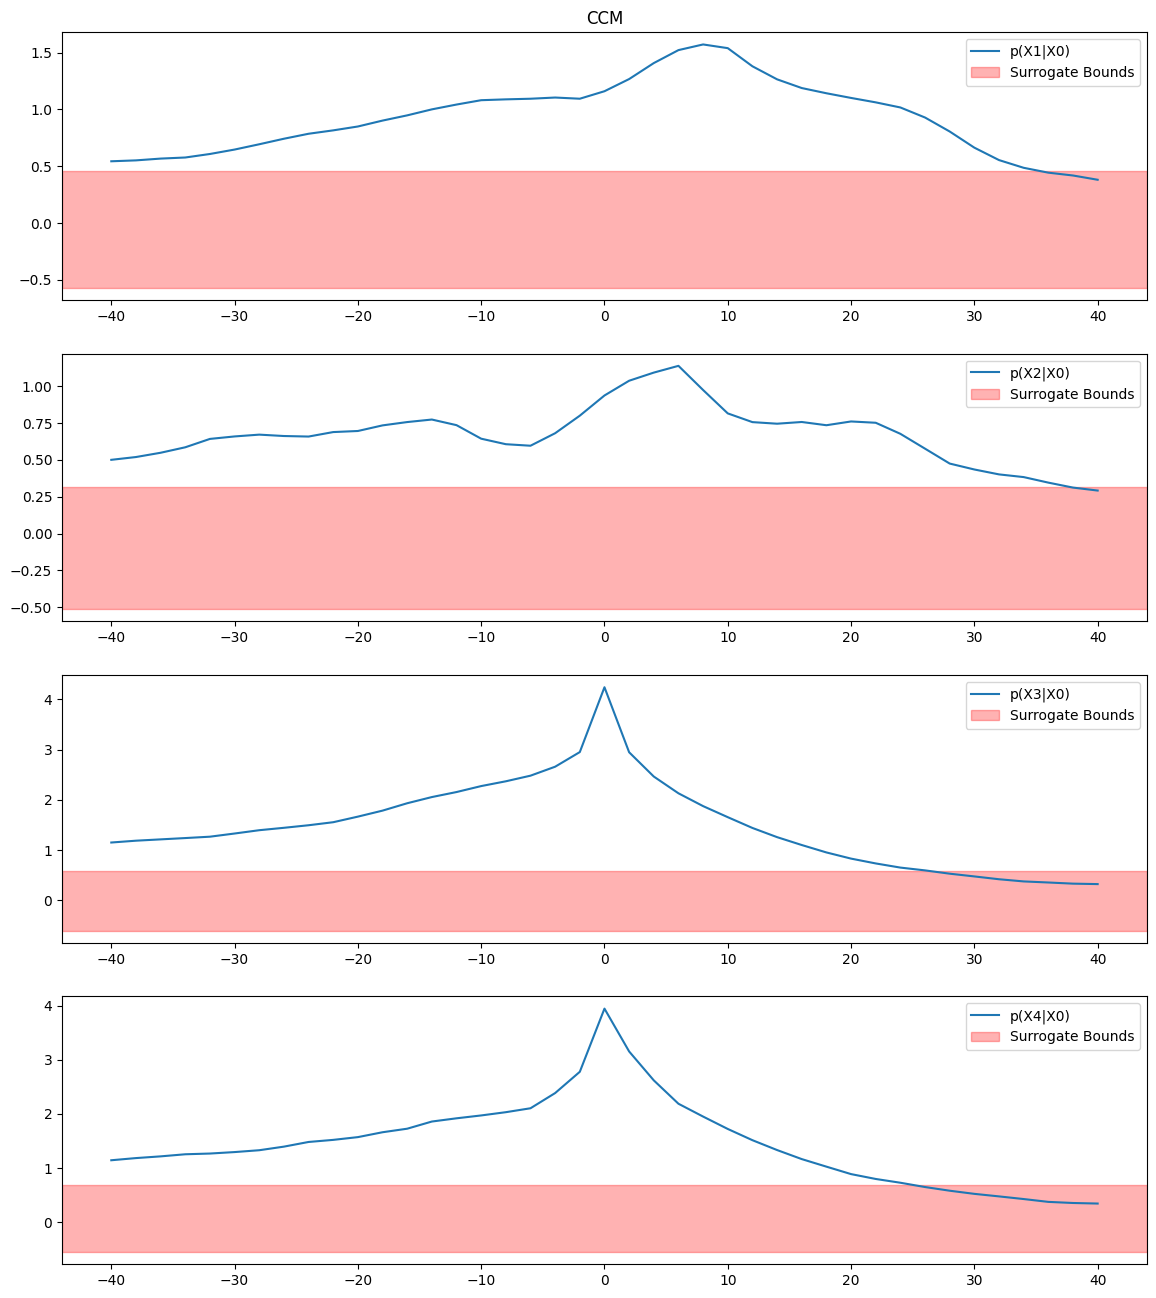

In [78]:
PlotSingleDimCCM(avg_fcf,lags,flat_surrs,pairs=[[0,1],[0,2],[0,3],[0,4]])

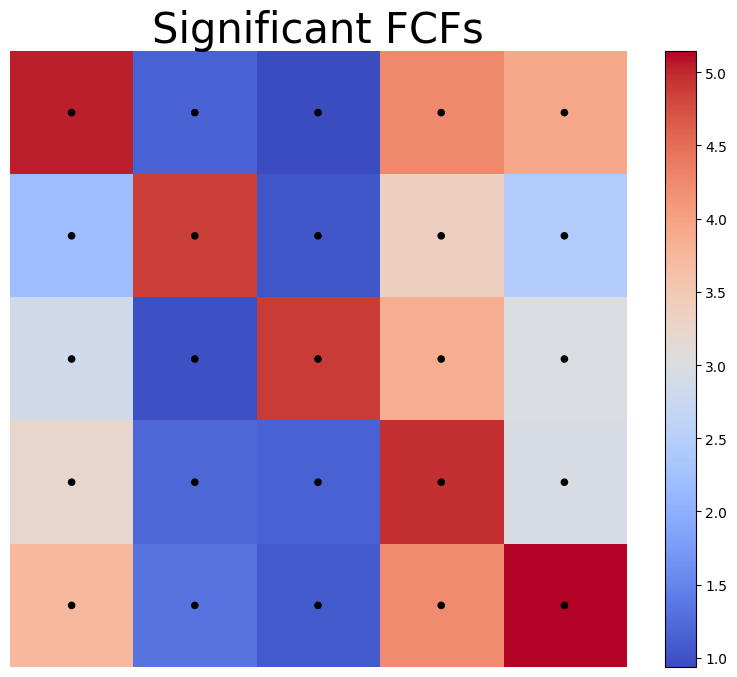

In [79]:
vis.visualize_matrix(avg_fcf[:,:,zero_lag],pval=(avg_fcf[:,:,zero_lag]>surrogate_maxes),titlestr='Significant FCFs')

In [81]:
pvals = fcf_vals[2]
opt_lag_arrs = np.argmax(avg_fcf,axis=2)
opt_lags = lag_arr[opt_lag_arrs.flatten()].reshape(opt_lag_arrs.shape)*delay*dt

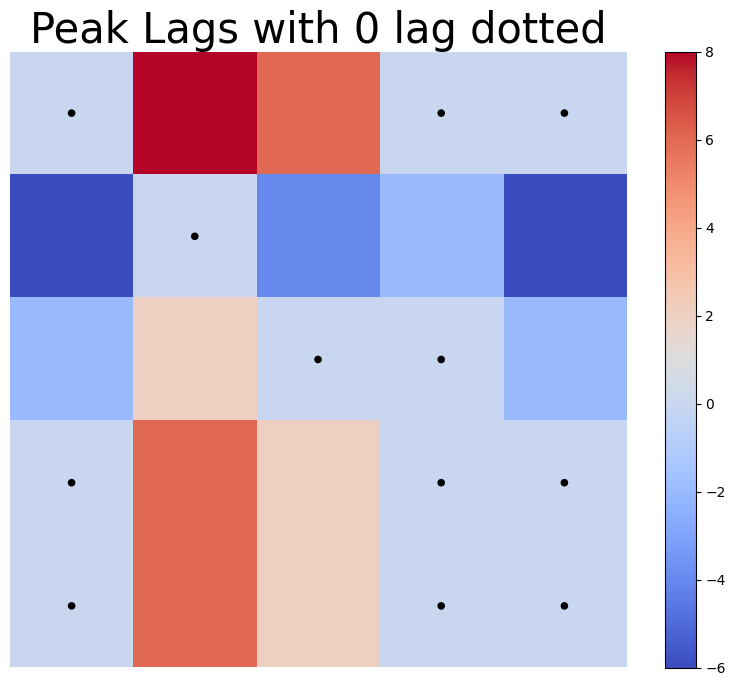

In [82]:
vis.visualize_matrix(opt_lags,titlestr='Peak Lags with 0 lag dotted',pval=(opt_lags==0))

In [83]:
fcf_predicted_connections = np.logical_and(pvals[:,:,zero_lag]<=0.01,opt_lags==0)

In [84]:
acc_matrix = (np.abs(W)>0).astype(int)-fcf_predicted_connections.astype(int)

Color Coding of Accuracy Matrix (Assuming that the weight matrix is the actual perturbation connections):

White = Correct Prediction

Red = FCF did not predict a connection when there was one

Blue = FCF predicted a connection that is not there

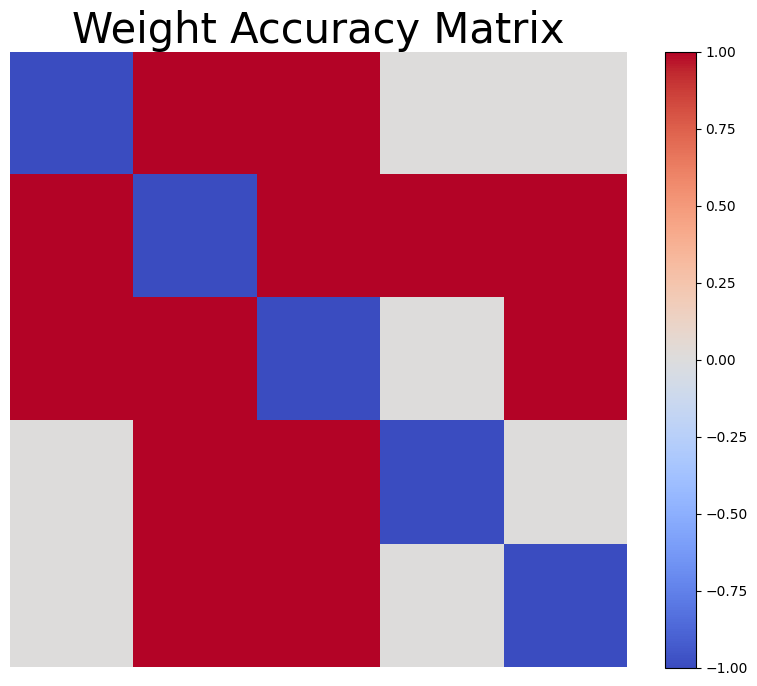

In [86]:
vis.visualize_matrix(acc_matrix,titlestr='Weight Accuracy Matrix')

In [87]:
true_positives = np.argwhere(np.logical_and((np.abs(W)>0),opt_lags==0))
true_negatives = np.argwhere(np.logical_and((np.abs(W)==0),opt_lags!=0))
false_positives = np.argwhere(acc_matrix==-1)
false_negatives = np.argwhere(acc_matrix==1)

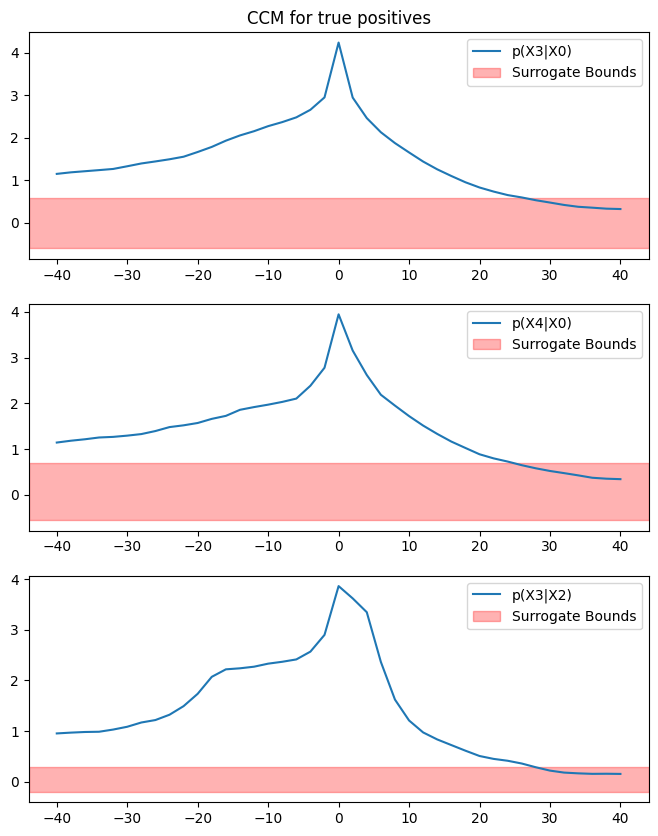

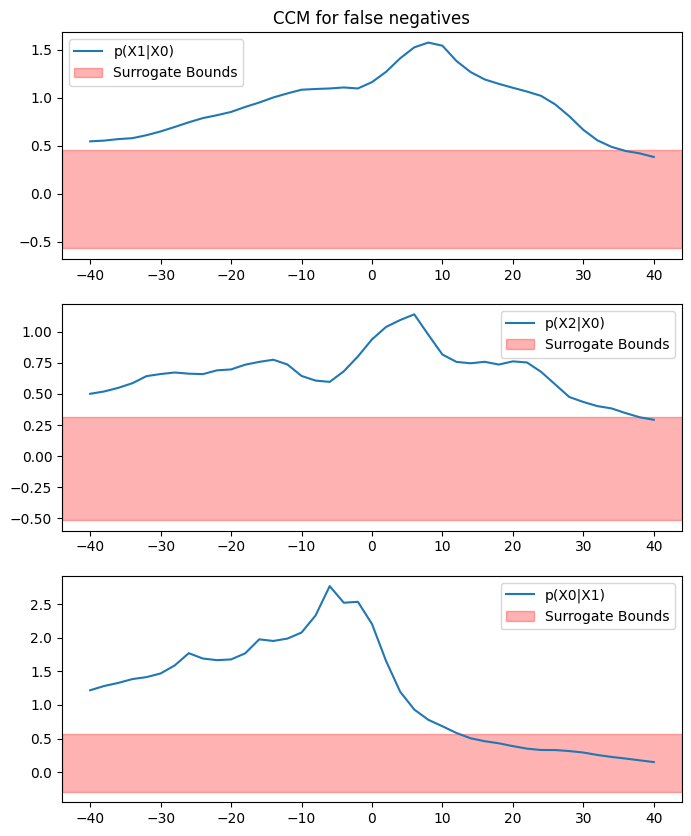

In [90]:
PlotSingleDimCCM(avg_fcf,lag_arr*delay*dt,flat_surrs,pairs=[true_positives[0,:],true_positives[1,:],true_positives[2,:]],figsize=(8,10),titlestr='CCM for true positives')
PlotSingleDimCCM(avg_fcf,lag_arr*delay*dt,flat_surrs,pairs=[false_negatives[0,:],false_negatives[1,:],false_negatives[2,:]],figsize=(8,10),titlestr='CCM for false negatives')


### Interventional Connectivity

Here we will compute the interventional connectivity between the neurons by perturbing the neurons over many trials and testing if other neurons' distributions are perturbed after.

In [60]:
def StimRNN(t_start,t_end,N_t_eval,stim_len,stim_amp,stim_node,N_trials,t_out_start = 0,tau=1,J=W,phi=np.tanh,bias=b):
    def In(t):
        out = np.zeros(5)
        out[stim_node] = int(t > 0 and t < stim_len)*stim_amp
        return out
    
    all_timeseries = [np.random.uniform(0.1,0.6,5) for i in range(N_trials)]
    
    def dX(t,X):
        return (-X+phi(J@X+bias) + In(t))/tau
    t_eval = np.linspace(t_out_start,t_end,N_t_eval)
    for i in range(N_trials):
        sol = integrate.solve_ivp(dX,[t_start,t_end],all_timeseries[i],t_eval=t_eval)
        all_timeseries[i] = [sol.t,sol.y]    

    return all_timeseries[0][0], np.dstack([all_timeseries[i][1] for i in range(N_trials)])

In [70]:
def StimAllRNN(t_start,t_end,N_t_eval,stim_len,stim_amp,N_trials,t_out_start = 0,tau=1,J=W,phi=relu,bias=b):
    sols = [[] for i in range(5)]
    for i in range(5):
        sols[i] = StimRNN(t_start=t_start,t_end=t_end,N_t_eval=N_t_eval,stim_len=stim_len,stim_amp=stim_amp,N_trials=N_trials,t_out_start=t_out_start,stim_node=i,J=J,phi=phi,bias=bias)
    return sols

In [67]:
pre_time = -350
t_end = 20
stim_len = 0.1
stim_amp = 0.5
stim_node = 0
N_trials = 1000
N_t_eval = 4000
t_out_start = pre_time

In [71]:
all_stims = StimAllRNN(t_start=pre_time,t_end=t_end,stim_len=stim_len,stim_amp=stim_amp,N_trials=N_trials,t_out_start=t_out_start,J=W,phi=relu,bias=b,N_t_eval=N_t_eval)

In [65]:
stim0 = StimRNN(t_start=pre_time,t_end=t_end,stim_len=stim_len,stim_amp=stim_amp,stim_node=stim_node,N_trials=N_trials,phi=relu,N_t_eval=N_t_eval,t_out_start=t_out_start)

In [78]:
def PlotStimActivities(stimsols,figsize=(10,30)):
    fig, axs = plt.subplots(nrows=len(stimsols),figsize=figsize)
    for j in range(len(stimsols)):
        for i in range(5):
            axs[j].plot(stimsols[j][0],np.nanmean(stimsols[j][1][i,:,:],axis=1).T,label=f'Neuron {i}')
        axs[j].axvspan(0,stim_len,color=[1,0,0,0.2],label=f'Stimulus on {j}')
        axs[j].legend()
    axs[0].set_title('Averaged Activity over trials')
    axs[-1].set_xlabel('t')
    plt.show()

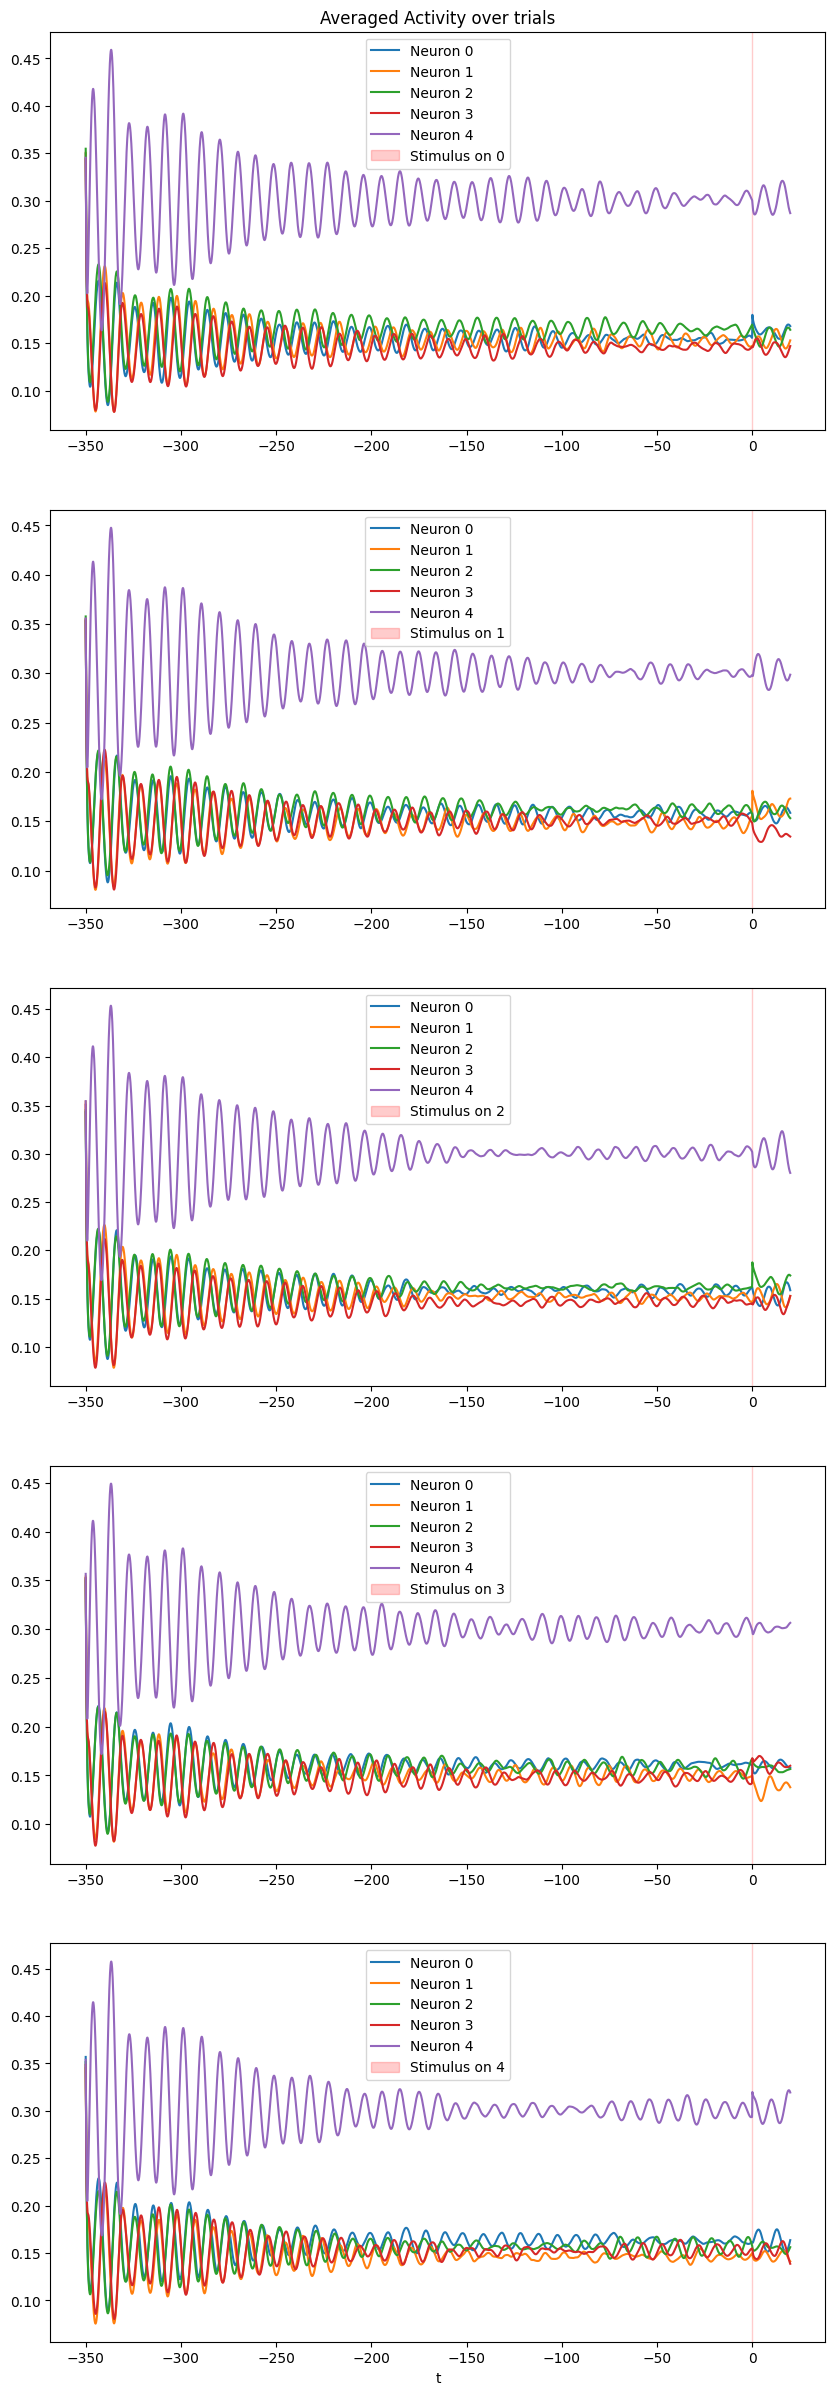

In [79]:
PlotStimActivities(all_stims)

In [141]:
import scipy.stats as stats
def OneInputIC(sols,stim_len,window_width=1,max_step=4,dist_method='kstest',ignore_stim=1,concat_method = 'mean'):
    times = sols[0]
    max_step = np.min([max_step,int(times[-1]//window_width)]) #To make sure we don't extrapolate too far
    N = sols[1].shape[0]
    pre_times = np.argwhere(np.logical_and(times<0,times>(-window_width)))
    pre_dist=[]
    if concat_method == 'flatten':
        pre_dist = [sols[1][i,pre_times,:].flatten() for i in range(N)]
    elif concat_method=='mean':
        pre_dist = [np.nanmean(sols[1][i,pre_times,:],axis=0).flatten() for i in range(N)]
    pst_dists = [[] for s in range(max_step)]
    for step in range(max_step):
        pst_times = np.argwhere(np.logical_and(times>window_width*step+ignore_stim*stim_len,times<(window_width*(step+1)+ignore_stim*stim_len)))
        if concat_method=='flatten':
            pst_dists[step] = [sols[1][i,pst_times,:].flatten() for i in range(N)]
        elif concat_method=='mean':
            pst_dists[step] = [np.nanmean(sols[1][i,pst_times,:],axis=0).flatten() for i in range(N)]
    #print(pst_dists[0][0].shape)
    ic_stats = [[stats.kstest(pst_dists[i][j],pre_dist[j]) for i in range(max_step)] for j in range(N)]
    IC = [[ic_stats[j][i].statistic for i in range(max_step)] for j in range(N)]
    ICpvals = [[ic_stats[j][i].pvalue for i in range(max_step)] for j in range(N)]
    
    return np.array(IC), np.array(ICpvals)

def FullIC(sols,stim_len,window_t=1,max_step=4,dist_method='kstest',concat_method ='mean',ignore_stim=1):
    AllICs = [[] for i in range(len(sols))]
    AllICpvals = [[] for i in range(len(sols))]
    for i in range(len(sols)):
        AllICs[i], AllICpvals[i] = OneInputIC(sols[i],stim_len=stim_len,window_width=window_t,max_step=max_step,dist_method=dist_method,concat_method=concat_method,ignore_stim=ignore_stim)
    return AllICs, AllICpvals

In [179]:
ICs,ICpvals = FullIC(all_stims,stim_len=stim_len,window_t=2,max_step=10)

In [180]:
def BestICMatrices(ICs,ICpvals):
    ic = np.array(ICs)
    icp = np.array(ICpvals)
    lags= np.argmax(ic,axis=2)
    bestIC = np.array([[ic[i,j,lags[i,j]] for i in range(len(ICs))] for j in range(ICs[0].shape[0])])
    bestICpval = np.array([[icp[i,j,lags[i,j]] for i in range(len(ICs))] for j in range(ICs[0].shape[0])])
    return bestIC,bestICpval,lags

In [181]:
bic, bicp,iclag = BestICMatrices(ICs,ICpvals)

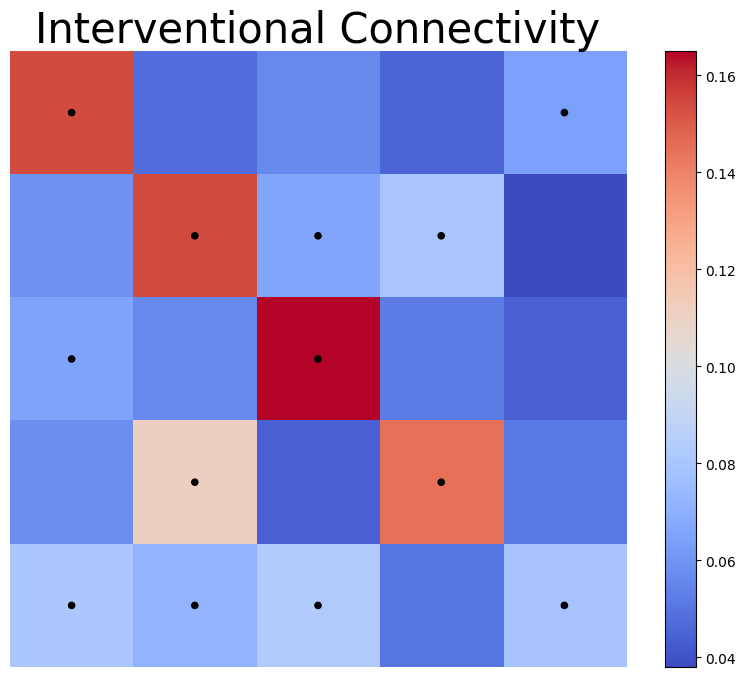

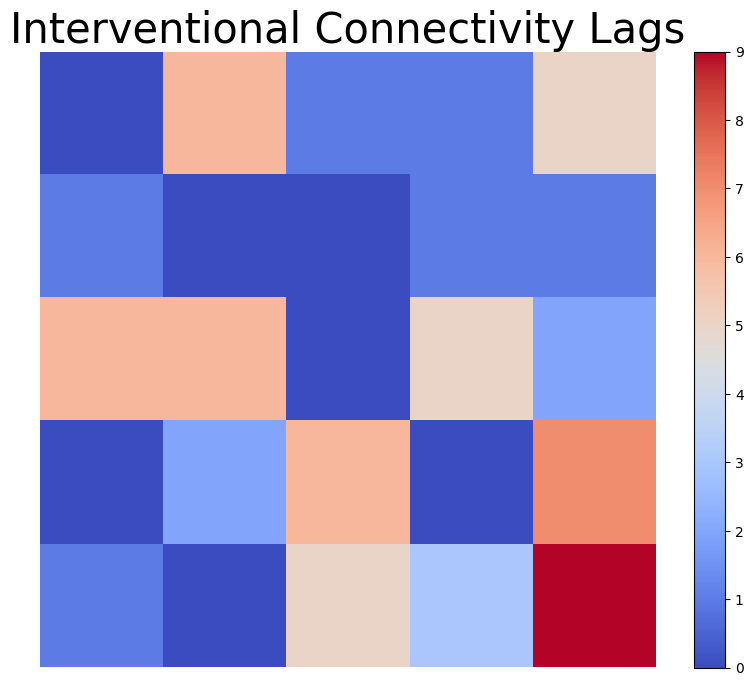

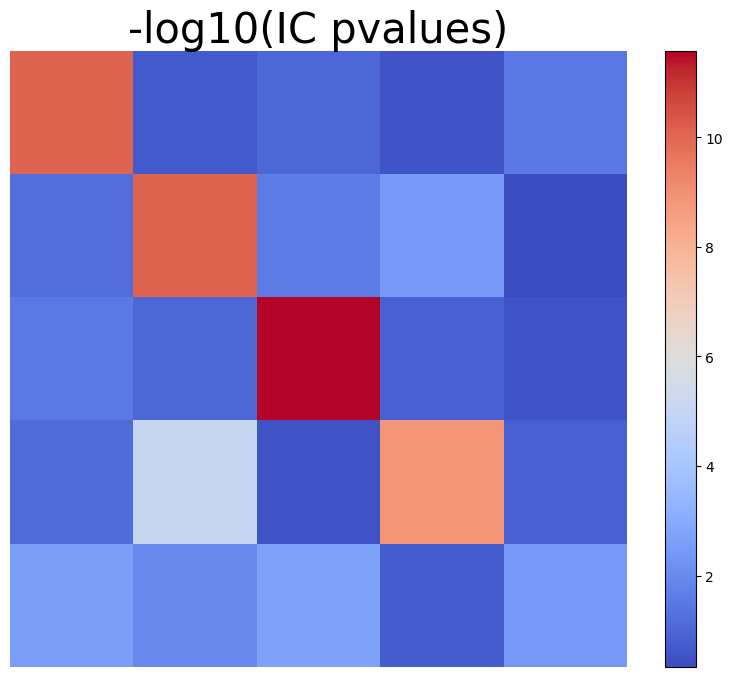

In [182]:
vis.visualize_matrix(bic,pval=(bicp<=0.05),titlestr='Interventional Connectivity')
vis.visualize_matrix(iclag,titlestr='Interventional Connectivity Lags')
vis.visualize_matrix(-np.log10(bicp),titlestr='-log10(IC pvalues)')